<a href="https://colab.research.google.com/github/sakasa/notebooks/blob/master/tokyo_covid19_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from pytz import timezone
import numpy as np

%matplotlib inline

### Tokyo COVID19 Data
https://github.com/tokyo-metropolitan-gov/covid19

In [31]:
url = 'https://raw.githubusercontent.com/tokyo-metropolitan-gov/covid19/development/data/data.json'

In [32]:
response = requests.get(url)
print(response)
j_res = json.loads(response.text) # json文字列をdictへ
print(j_res.keys())
j_res['patients_summary']['data'][-15:]

<Response [200]>
dict_keys(['contacts', 'querents', 'patients_summary', 'inspections_summary', 'lastUpdate', 'main_summary'])


[{'小計': 944, '日付': '2020-12-30T08:00:00.000Z'},
 {'小計': 1337, '日付': '2020-12-31T08:00:00.000Z'},
 {'小計': 783, '日付': '2021-01-01T08:00:00.000Z'},
 {'小計': 814, '日付': '2021-01-02T08:00:00.000Z'},
 {'小計': 816, '日付': '2021-01-03T08:00:00.000Z'},
 {'小計': 884, '日付': '2021-01-04T08:00:00.000Z'},
 {'小計': 1278, '日付': '2021-01-05T08:00:00.000Z'},
 {'小計': 1591, '日付': '2021-01-06T08:00:00.000Z'},
 {'小計': 2447, '日付': '2021-01-07T08:00:00.000Z'},
 {'小計': 2392, '日付': '2021-01-08T08:00:00.000Z'},
 {'小計': 2268, '日付': '2021-01-09T08:00:00.000Z'},
 {'小計': 1494, '日付': '2021-01-10T08:00:00.000Z'},
 {'小計': 1219, '日付': '2021-01-11T08:00:00.000Z'},
 {'小計': 970, '日付': '2021-01-12T08:00:00.000Z'},
 {'小計': 1433, '日付': '2021-01-13T08:00:00.000Z'}]

In [33]:
def utc_datestr_to_jst_date(datestr):
  #return datetime.datetime.fromisoformat(datestr.replace('Z', '+00:00')).astimezone(timezone('Asia/Tokyo'))
  # for ~Python3.6
  return datetime.datetime.strptime(datestr.split('.')[0].replace('-', '').replace(':', ''), '%Y%m%dT%H%M%S').astimezone(timezone('Asia/Tokyo'))

In [34]:
keys = ['contacts', 'querents', 'patients_summary']

In [35]:
d = j_res
df = pd.DataFrame()
for key in keys:
  k = f'{key.split("_")[0]}_count'
  for v in d[key].values():
    if type(v) is list:
      index = [_v['日付'] for _v in v]
      tmp_df = pd.DataFrame(_v for _v in v)
      tmp_df.index = [utc_datestr_to_jst_date(dt) for dt in tmp_df['日付']]
      tmp_df[k] = tmp_df['小計']
  df = pd.concat([df, tmp_df[k]], axis=1)
df = df.fillna(0).astype('int64')
df.index = [i for i in df.index]
df['datetime'] = df.index
df

,contacts_count,querents_count,patients_count,datetime
2020-01-24 17:00:00+09:00,0,0,1,2020-01-24 17:00:00+09:00
2020-01-25 17:00:00+09:00,0,0,1,2020-01-25 17:00:00+09:00
2020-01-26 17:00:00+09:00,0,0,0,2020-01-26 17:00:00+09:00
2020-01-27 17:00:00+09:00,0,0,0,2020-01-27 17:00:00+09:00
2020-01-28 17:00:00+09:00,0,0,0,2020-01-28 17:00:00+09:00
...,...,...,...,...
2021-01-09 17:00:00+09:00,1680,0,2268,2021-01-09 17:00:00+09:00
2021-01-10 17:00:00+09:00,1374,0,1494,2021-01-10 17:00:00+09:00
2021-01-11 17:00:00+09:00,1278,0,1219,2021-01-11 17:00:00+09:00
2021-01-12 17:00:00+09:00,1226,0,970,2021-01-12 17:00:00+09:00


In [36]:
# 7日移動平均
df1 = df
for key in keys:
  k = key.split('_')[0]
  df1[f'{k}_7d_mov_ave'] = df[f'{k}_count'].rolling('7D').mean()
  # df1[f'{k}_7d_mov_center_ave'] = df[f'{k}_count'].rolling(7, center=True).mean()
  df1[f'{k}_7d_mov_sum'] = df[f'{k}_count'].rolling('7D').sum()
df1.tail()

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum
2021-01-09 17:00:00+09:00,1680,0,2268,2021-01-09 17:00:00+09:00,1336.571429,9356.0,0.0,0.0,1668.000000,11676.0
2021-01-10 17:00:00+09:00,1374,0,1494,2021-01-10 17:00:00+09:00,1377.000000,9639.0,0.0,0.0,1764.857143,12354.0
2021-01-11 17:00:00+09:00,1278,0,1219,2021-01-11 17:00:00+09:00,1392.142857,9745.0,0.0,0.0,1812.714286,12689.0
2021-01-12 17:00:00+09:00,1226,0,970,2021-01-12 17:00:00+09:00,1389.571429,9727.0,0.0,0.0,1768.714286,12381.0
2021-01-13 17:00:00+09:00,0,0,1433,2021-01-13 17:00:00+09:00,1200.142857,8401.0,0.0,0.0,1746.142857,12223.0


In [37]:
df2 = df1
# 日付が年の何週目かを列にセット `'{yy}w{week nnum}`
df2['week_num'] = [f'\'{d.strftime("%y")}w{d.strftime("%V")}' for d in df1.index]
# 曜日の列をセット
df2['week_day'] = [d.strftime('%a') for d in df1.index]
df2.tail(15)

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum,week_num,week_day
2020-12-30 17:00:00+09:00,1443,0,944,2020-12-30 17:00:00+09:00,1002.571429,7018.0,0.0,0.0,815.714286,5710.0,'20w53,Wed
2020-12-31 17:00:00+09:00,1196,0,1337,2020-12-31 17:00:00+09:00,1070.714286,7495.0,0.0,0.0,879.857143,6159.0,'20w53,Thu
2021-01-01 17:00:00+09:00,948,0,783,2021-01-01 17:00:00+09:00,1108.428571,7759.0,0.0,0.0,865.428571,6058.0,'21w53,Fri
2021-01-02 17:00:00+09:00,1146,0,814,2021-01-02 17:00:00+09:00,1126.571429,7886.0,0.0,0.0,846.142857,5923.0,'21w53,Sat
2021-01-03 17:00:00+09:00,1091,0,816,2021-01-03 17:00:00+09:00,1153.571429,8075.0,0.0,0.0,861.571429,6031.0,'21w53,Sun
2021-01-04 17:00:00+09:00,1172,0,884,2021-01-04 17:00:00+09:00,1195.428571,8368.0,0.0,0.0,919.142857,6434.0,'21w01,Mon
2021-01-05 17:00:00+09:00,1244,0,1278,2021-01-05 17:00:00+09:00,1177.142857,8240.0,0.0,0.0,979.428571,6856.0,'21w01,Tue
2021-01-06 17:00:00+09:00,1326,0,1591,2021-01-06 17:00:00+09:00,1160.428571,8123.0,0.0,0.0,1071.857143,7503.0,'21w01,Wed
2021-01-07 17:00:00+09:00,1493,0,2447,2021-01-07 17:00:00+09:00,1202.857143,8420.0,0.0,0.0,1230.428571,8613.0,'21w01,Thu
2021-01-08 17:00:00+09:00,1350,0,2392,2021-01-08 17:00:00+09:00,1260.285714,8822.0,0.0,0.0,1460.285714,10222.0,'21w01,Fri


In [38]:
# 週毎に集計
groupby_week_num = df2.groupby('week_num', as_index=True)

In [39]:
# 集計結果から平均と合計を取得しデータフレームにセット
patients_week_num_df = pd.DataFrame({
    # 'patients_week_num': df2['week_num'].unique(),
    'patients_week_mean': [m for m in groupby_week_num.agg({'patients_count': 'mean'})['patients_count']], 
    'patients_week_sum': [s for s in groupby_week_num.agg({'patients_count': 'sum'})['patients_count']]
  }, index=[d for d in groupby_week_num.agg({'datetime': 'max'})['datetime']])
patients_week_num_df.tail()

,patients_week_mean,patients_week_sum
2020-12-27 17:00:00+09:00,733.142857,5132
2020-12-31 17:00:00+09:00,904.500000,3618
2021-01-10 17:00:00+09:00,1764.857143,12354
2021-01-13 17:00:00+09:00,1207.333333,3622
2021-01-03 17:00:00+09:00,804.333333,2413


In [40]:
df3 = pd.concat([
                df2,
                patients_week_num_df.loc[:, ['patients_week_mean', 'patients_week_sum']]
                ], axis=1)
df3.tail(15)

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum,week_num,week_day,patients_week_mean,patients_week_sum
2020-12-30 17:00:00+09:00,1443,0,944,2020-12-30 17:00:00+09:00,1002.571429,7018.0,0.0,0.0,815.714286,5710.0,'20w53,Wed,NaN,NaN
2020-12-31 17:00:00+09:00,1196,0,1337,2020-12-31 17:00:00+09:00,1070.714286,7495.0,0.0,0.0,879.857143,6159.0,'20w53,Thu,904.500000,3618.0
2021-01-01 17:00:00+09:00,948,0,783,2021-01-01 17:00:00+09:00,1108.428571,7759.0,0.0,0.0,865.428571,6058.0,'21w53,Fri,NaN,NaN
2021-01-02 17:00:00+09:00,1146,0,814,2021-01-02 17:00:00+09:00,1126.571429,7886.0,0.0,0.0,846.142857,5923.0,'21w53,Sat,NaN,NaN
2021-01-03 17:00:00+09:00,1091,0,816,2021-01-03 17:00:00+09:00,1153.571429,8075.0,0.0,0.0,861.571429,6031.0,'21w53,Sun,804.333333,2413.0
2021-01-04 17:00:00+09:00,1172,0,884,2021-01-04 17:00:00+09:00,1195.428571,8368.0,0.0,0.0,919.142857,6434.0,'21w01,Mon,NaN,NaN
2021-01-05 17:00:00+09:00,1244,0,1278,2021-01-05 17:00:00+09:00,1177.142857,8240.0,0.0,0.0,979.428571,6856.0,'21w01,Tue,NaN,NaN
2021-01-06 17:00:00+09:00,1326,0,1591,2021-01-06 17:00:00+09:00,1160.428571,8123.0,0.0,0.0,1071.857143,7503.0,'21w01,Wed,NaN,NaN
2021-01-07 17:00:00+09:00,1493,0,2447,2021-01-07 17:00:00+09:00,1202.857143,8420.0,0.0,0.0,1230.428571,8613.0,'21w01,Thu,NaN,NaN
2021-01-08 17:00:00+09:00,1350,0,2392,2021-01-08 17:00:00+09:00,1260.285714,8822.0,0.0,0.0,1460.285714,10222.0,'21w01,Fri,NaN,NaN


### グラフ出力

In [41]:
### 日毎の数
x = df3.index
y1_1 = df3['patients_count']
y1_2 = df3['patients_7d_mov_ave']
#y1_3 = df3['patients_7d_mov_center_ave']
y1_4 = df3['patients_week_mean']

In [42]:
### 週毎の数
y2_1 = df3['patients_7d_mov_sum']
y2_2 = df3['patients_week_sum']

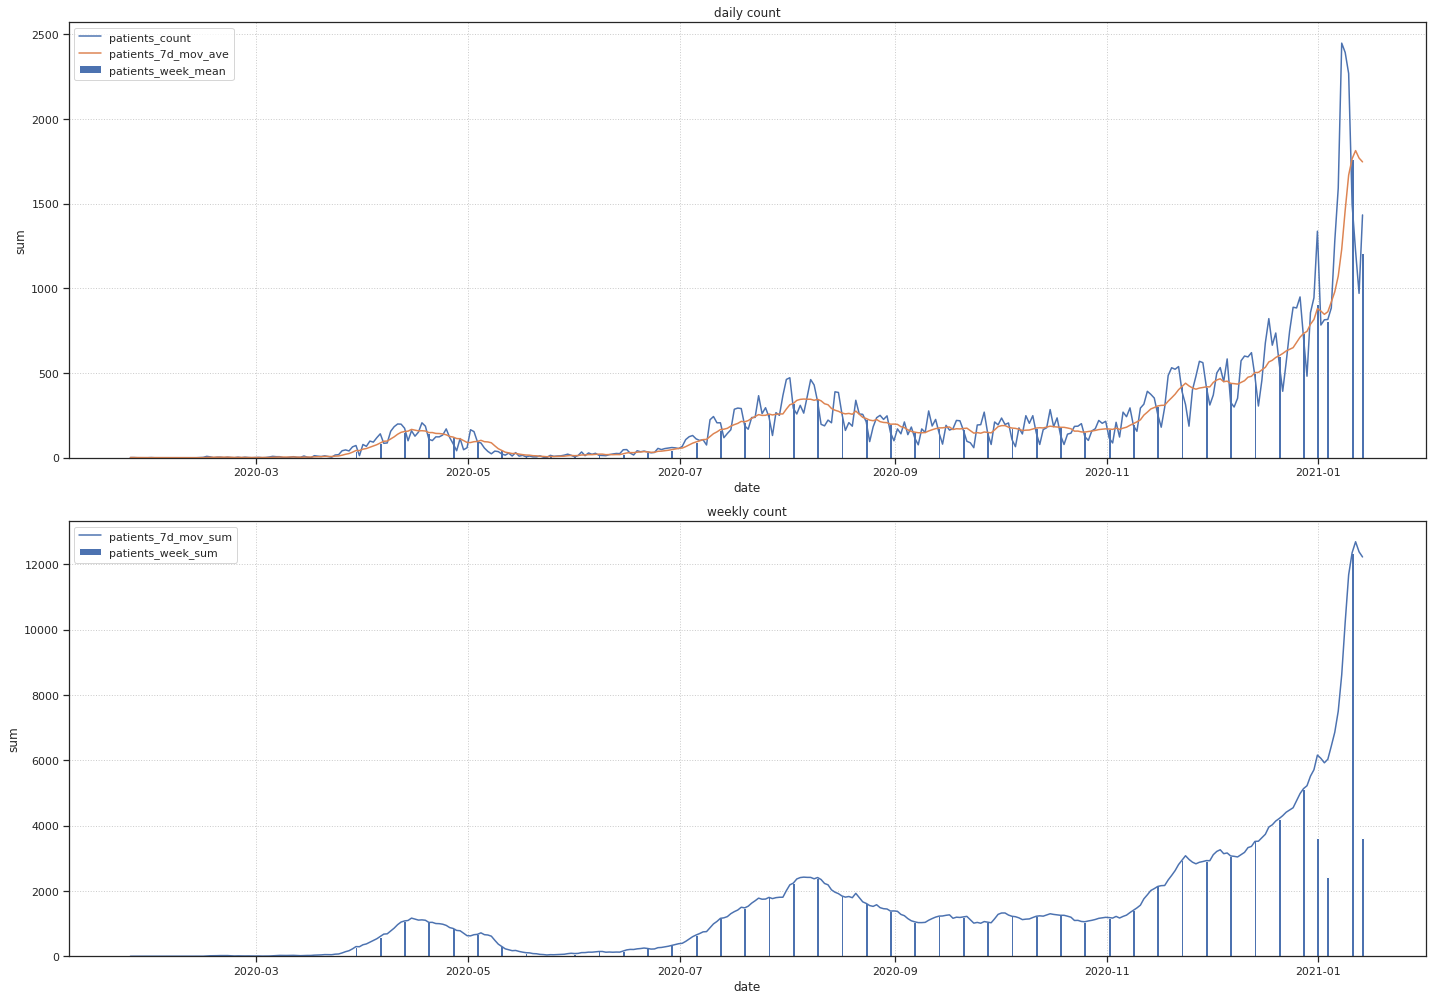

In [43]:
fig, ax = plt.subplots(2, 1, figsize=(20, 14))

### 日毎の数
ax[0].set_title('daily count')
ax[0].set_xlabel('date')
ax[0].set_ylabel('sum')
ax[0].plot(x, y1_1, label='patients_count')
ax[0].plot(x, y1_2, label='patients_7d_mov_ave')
#ax[0].plot(x, y1_3, label='patients_7d_mov_center_ave')
ax[0].bar(x, y1_4, label='patients_week_mean')
ax[0].grid(linestyle=':')
ax[0].legend()

### 週毎の合計
ax[1].set_title('weekly count')
ax[1].set_xlabel('date')
ax[1].set_ylabel('sum')
ax[1].plot(x, y2_1, label='patients_7d_mov_sum')
ax[1].bar(x, y2_2, label='patients_week_sum')
ax[1].grid(linestyle=':')
ax[1].legend()

plt.tight_layout()

---

In [44]:
def get_date(d: datetime) -> datetime:
  """時間が入った `datetime` を `%Y-%m-%d 00:00:00` の `datetime` に変換します"""
  return datetime.datetime.strptime(d.strftime('%Y-%m-%d'), '%Y-%m-%d')

In [45]:
em_start = datetime.datetime(2020, 4, 7)
em_end = datetime.datetime(2020, 5, 25)
def em_term() -> list:
  """緊急事態宣言期間の日付のリスト"""
  em_term = []
  for i in range((em_end - em_start).days + 1):
    em_term.append(em_start + datetime.timedelta(i))
  return em_term

In [46]:
def emergency(d: datetime) -> int:
  """緊急事態宣言期間中か"""
  return int(get_date(d) in em_term())

In [47]:
def em_passed(d: datetime) -> int:
  """緊急事態宣言から経過日数"""
  d = get_date(d)
  return (d - em_start).days if em_start < d else 0

In [48]:
ds_df = pd.DataFrame({
    'timestamp': [d.timestamp() for d in df3.index], # タイムスタンプ
    'year': np.array(df3.index.strftime('%Y'), dtype=np.int64), # 年
    'month': np.array(df3.index.strftime('%m'), dtype=np.int64), # 月
    'day': np.array(df3.index.strftime('%d'), dtype=np.int64), # 日
    'week_day': df3['week_day'], # 曜日
})
# 曜日をダミー変数化
ds_df = pd.concat([ds_df, pd.get_dummies(ds_df['week_day'])], axis=1)
ds_df = ds_df.drop(columns=['week_day'])

# 経過日数
# ds_df['passed'] = [(d - df3['datetime'][0]).days for d in df3['datetime']]
ds_df['passed'] = [(d - df3.index[0]).days for d in df3.index]
# 緊急事態宣言期間中
ds_df['emergency'] = [emergency(d) for d in df3.index]
# 緊急事態宣言経過日数
ds_df['em_passed'] = [em_passed(d) for d in df3.index]
for key in keys:
  k = key.split('_')[0]
  # 日毎の数
  ds_df[f'{k}_count'] = df3[f'{k}_count']
  # 7日間移動平均
  ds_df[f'{k}_7d_mov_ave'] = df3[f'{k}_7d_mov_ave']
  #ds_df[f'{k}_7d_mov_center_ave'] = df3[f'{k}_7d_mov_center_ave']
  # 7日間移動合計
  ds_df[f'{k}_7d_mov_sum'] = df3[f'{k}_7d_mov_sum']

# 日毎の数
# ds_df['patients_count'] = df3['patients_count']
# 7日間移動平均
# ds_df['patients_7d_mov_ave'] = df3['patients_7d_mov_ave']
#ds_df['7d_mov_center_ave'] = df3['patients_7d_mov_center_ave']
# 7日間移動合計
# ds_df['patients_7d_mov_sum'] = df3['patients_7d_mov_sum']

ds_df = ds_df.reset_index(drop=True)
ds_df.tail(15)

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
341,1.609315e+09,2020,12,30,0,0,0,0,0,0,1,341,0,267,1443,1002.571429,7018.0,0,0.0,0.0,944,815.714286,5710.0
342,1.609402e+09,2020,12,31,0,0,0,0,1,0,0,342,0,268,1196,1070.714286,7495.0,0,0.0,0.0,1337,879.857143,6159.0
343,1.609488e+09,2021,1,1,1,0,0,0,0,0,0,343,0,269,948,1108.428571,7759.0,0,0.0,0.0,783,865.428571,6058.0
344,1.609574e+09,2021,1,2,0,0,1,0,0,0,0,344,0,270,1146,1126.571429,7886.0,0,0.0,0.0,814,846.142857,5923.0
345,1.609661e+09,2021,1,3,0,0,0,1,0,0,0,345,0,271,1091,1153.571429,8075.0,0,0.0,0.0,816,861.571429,6031.0
346,1.609747e+09,2021,1,4,0,1,0,0,0,0,0,346,0,272,1172,1195.428571,8368.0,0,0.0,0.0,884,919.142857,6434.0
347,1.609834e+09,2021,1,5,0,0,0,0,0,1,0,347,0,273,1244,1177.142857,8240.0,0,0.0,0.0,1278,979.428571,6856.0
348,1.609920e+09,2021,1,6,0,0,0,0,0,0,1,348,0,274,1326,1160.428571,8123.0,0,0.0,0.0,1591,1071.857143,7503.0
349,1.610006e+09,2021,1,7,0,0,0,0,1,0,0,349,0,275,1493,1202.857143,8420.0,0,0.0,0.0,2447,1230.428571,8613.0
350,1.610093e+09,2021,1,8,1,0,0,0,0,0,0,350,0,276,1350,1260.285714,8822.0,0,0.0,0.0,2392,1460.285714,10222.0


In [49]:
ds_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 356 entries, 0 to 355
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   timestamp            356 non-null    float64
 1   year                 356 non-null    int64  
 2   month                356 non-null    int64  
 3   day                  356 non-null    int64  
 4   Fri                  356 non-null    uint8  
 5   Mon                  356 non-null    uint8  
 6   Sat                  356 non-null    uint8  
 7   Sun                  356 non-null    uint8  
 8   Thu                  356 non-null    uint8  
 9   Tue                  356 non-null    uint8  
 10  Wed                  356 non-null    uint8  
 11  passed               356 non-null    int64  
 12  emergency            356 non-null    int64  
 13  em_passed            356 non-null    int64  
 14  contacts_count       356 non-null    int64  
 15  contacts_7d_mov_ave  356 non-null    flo

In [50]:
ds_df.describe()

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
count,3.560000e+02,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000
mean,1.595189e+09,2020.036517,6.668539,15.679775,0.143258,0.143258,0.143258,0.143258,0.140449,0.143258,0.143258,177.500000,0.137640,111.294944,765.078652,757.024813,5299.162921,1035.165730,1035.165730,7246.160112,220.691011,208.765770,1461.314607
std,8.891647e+06,0.187836,3.376342,8.921803,0.350829,0.350829,0.350829,0.350829,0.347942,0.350829,0.350829,102.912584,0.345007,92.324047,469.576872,453.682057,3175.792329,869.038554,739.346021,5175.422146,323.221888,282.196110,1975.406647
min,1.579853e+09,2020.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.587521e+09,2020.000000,4.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,88.750000,0.000000,14.750000,455.750000,459.321429,3215.250000,12.750000,74.142857,519.000000,21.750000,20.142857,141.000000
50%,1.595189e+09,2020.000000,7.000000,15.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,177.500000,0.000000,103.500000,606.500000,613.142857,4292.000000,1067.500000,1072.428571,7507.000000,140.500000,156.000000,1092.000000
75%,1.602857e+09,2020.000000,10.000000,24.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,266.250000,0.000000,192.250000,959.500000,946.428571,6625.000000,1664.000000,1573.428571,11014.000000,258.000000,254.785714,1783.500000
max,1.610525e+09,2021.000000,12.000000,31.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,355.000000,1.000000,281.000000,2265.000000,2096.857143,14678.000000,4060.000000,2574.142857,18019.000000,2447.000000,1812.714286,12689.000000


In [51]:
ds_df.corr()

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
timestamp,1.000000e+00,0.324886,0.783689,-0.018899,-0.009948,0.001990,-0.005969,-0.001990,4.239875e-19,0.005969,0.009948,1.000000e+00,-0.309057,0.988676,-0.032503,-0.015454,-0.015449,-0.212466,-0.208806,-0.208806,0.654192,0.697949,0.697977
year,3.248861e-01,1.000000,-0.327311,-0.189667,0.005884,0.005884,0.005884,0.005884,-3.559450e-02,0.005884,0.005884,3.248861e-01,-0.077777,0.345687,0.171881,0.206226,0.206225,-0.232224,-0.272959,-0.272959,0.720085,0.758914,0.758905
month,7.836894e-01,-0.327311,1.000000,0.021247,-0.014496,-0.002605,-0.009740,-0.004983,2.295452e-02,0.002151,0.006907,7.836894e-01,-0.255748,0.757943,-0.143921,-0.149321,-0.149314,-0.057418,-0.024622,-0.024622,0.178227,0.195910,0.195946
day,-1.889867e-02,-0.189667,0.021247,1.000000,0.007498,0.007498,-0.002402,-0.010501,9.991910e-03,-0.001502,-0.010501,-1.889867e-02,0.000632,-0.017528,-0.018334,-0.022663,-0.022668,0.020529,0.001033,0.001033,-0.067192,-0.066408,-0.066432
Fri,-9.947582e-03,0.005884,-0.014496,0.007498,1.000000,-0.167213,-0.167213,-0.167213,-1.652949e-01,-0.167213,-0.167213,-9.947582e-03,-0.000458,-0.008353,-0.022263,-0.008717,-0.008716,0.049047,-0.001606,-0.001606,0.043392,-0.013582,-0.013596
Mon,1.989516e-03,0.005884,-0.002605,0.007498,-0.167213,1.000000,-0.167213,-0.167213,-1.652949e-01,-0.167213,-0.167213,1.989516e-03,-0.000458,0.002084,0.043551,0.002235,0.002237,0.197965,-0.001606,-0.001606,-0.099471,0.006646,0.006650
Sat,-5.968549e-03,0.005884,-0.009740,-0.002402,-0.167213,-0.167213,1.000000,-0.167213,-1.652949e-01,-0.167213,-0.167213,-5.968549e-03,-0.000458,-0.004874,0.048270,-0.004470,-0.004468,-0.231457,-0.001606,-0.001606,0.055986,-0.004367,-0.004378
Sun,-1.989516e-03,0.005884,-0.004983,-0.010501,-0.167213,-0.167213,-0.167213,1.000000,-1.652949e-01,-0.167213,-0.167213,-1.989516e-03,-0.000458,-0.001395,-0.012859,-0.000996,-0.000994,-0.213357,-0.001606,-0.001606,-0.038684,0.001696,0.001695
Thu,4.239875e-19,-0.035594,0.022955,0.009992,-0.165295,-0.165295,-0.165295,-0.165295,1.000000e+00,-0.165295,-0.165295,4.471743e-18,0.002768,-0.002170,-0.006119,0.001278,0.001279,0.066904,0.009716,0.009716,0.067614,-0.017533,-0.017523
Tue,5.968549e-03,0.005884,0.002151,-0.001502,-0.167213,-0.167213,-0.167213,-0.167213,-1.652949e-01,1.000000,-0.167213,5.968549e-03,-0.000458,0.005562,-0.022502,0.005335,0.005336,0.078160,-0.001606,-0.001606,-0.036349,0.010586,0.010592


---

In [52]:
ds_df.columns

Index(['timestamp', 'year', 'month', 'day', 'Fri', 'Mon', 'Sat', 'Sun', 'Thu',
       'Tue', 'Wed', 'passed', 'emergency', 'em_passed', 'contacts_count',
       'contacts_7d_mov_ave', 'contacts_7d_mov_sum', 'querents_count',
       'querents_7d_mov_ave', 'querents_7d_mov_sum', 'patients_count',
       'patients_7d_mov_ave', 'patients_7d_mov_sum'],
      dtype='object')

In [53]:
_df = ds_df.copy()
_df = _df.drop(['year', 'month', 'day', 
          'contacts_7d_mov_ave', 'contacts_7d_mov_sum', 
          'querents_7d_mov_ave', 'querents_7d_mov_sum', 
          ], axis=1)
_df

,timestamp,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,querents_count,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
0,1.579853e+09,1,0,0,0,0,0,0,0,0,0,0,0,1,1.000000,1.0
1,1.579939e+09,0,0,1,0,0,0,0,1,0,0,0,0,1,1.000000,2.0
2,1.580026e+09,0,0,0,1,0,0,0,2,0,0,0,0,0,0.666667,2.0
3,1.580112e+09,0,1,0,0,0,0,0,3,0,0,0,0,0,0.500000,2.0
4,1.580198e+09,0,0,0,0,0,1,0,4,0,0,0,0,0,0.400000,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
351,1.610179e+09,0,0,1,0,0,0,0,351,0,277,1680,0,2268,1668.000000,11676.0
352,1.610266e+09,0,0,0,1,0,0,0,352,0,278,1374,0,1494,1764.857143,12354.0
353,1.610352e+09,0,1,0,0,0,0,0,353,0,279,1278,0,1219,1812.714286,12689.0
354,1.610438e+09,0,0,0,0,0,1,0,354,0,280,1226,0,970,1768.714286,12381.0


In [54]:
_df2 = _df[['timestamp', 'passed', 'emergency', 'patients_count', 'patients_7d_mov_ave', 'patients_7d_mov_sum']]
_df2

,timestamp,passed,emergency,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
0,1.579853e+09,0,0,1,1.000000,1.0
1,1.579939e+09,1,0,1,1.000000,2.0
2,1.580026e+09,2,0,0,0.666667,2.0
3,1.580112e+09,3,0,0,0.500000,2.0
4,1.580198e+09,4,0,0,0.400000,2.0
...,...,...,...,...,...,...
351,1.610179e+09,351,0,2268,1668.000000,11676.0
352,1.610266e+09,352,0,1494,1764.857143,12354.0
353,1.610352e+09,353,0,1219,1812.714286,12689.0
354,1.610438e+09,354,0,970,1768.714286,12381.0


In [55]:
import seaborn as sns

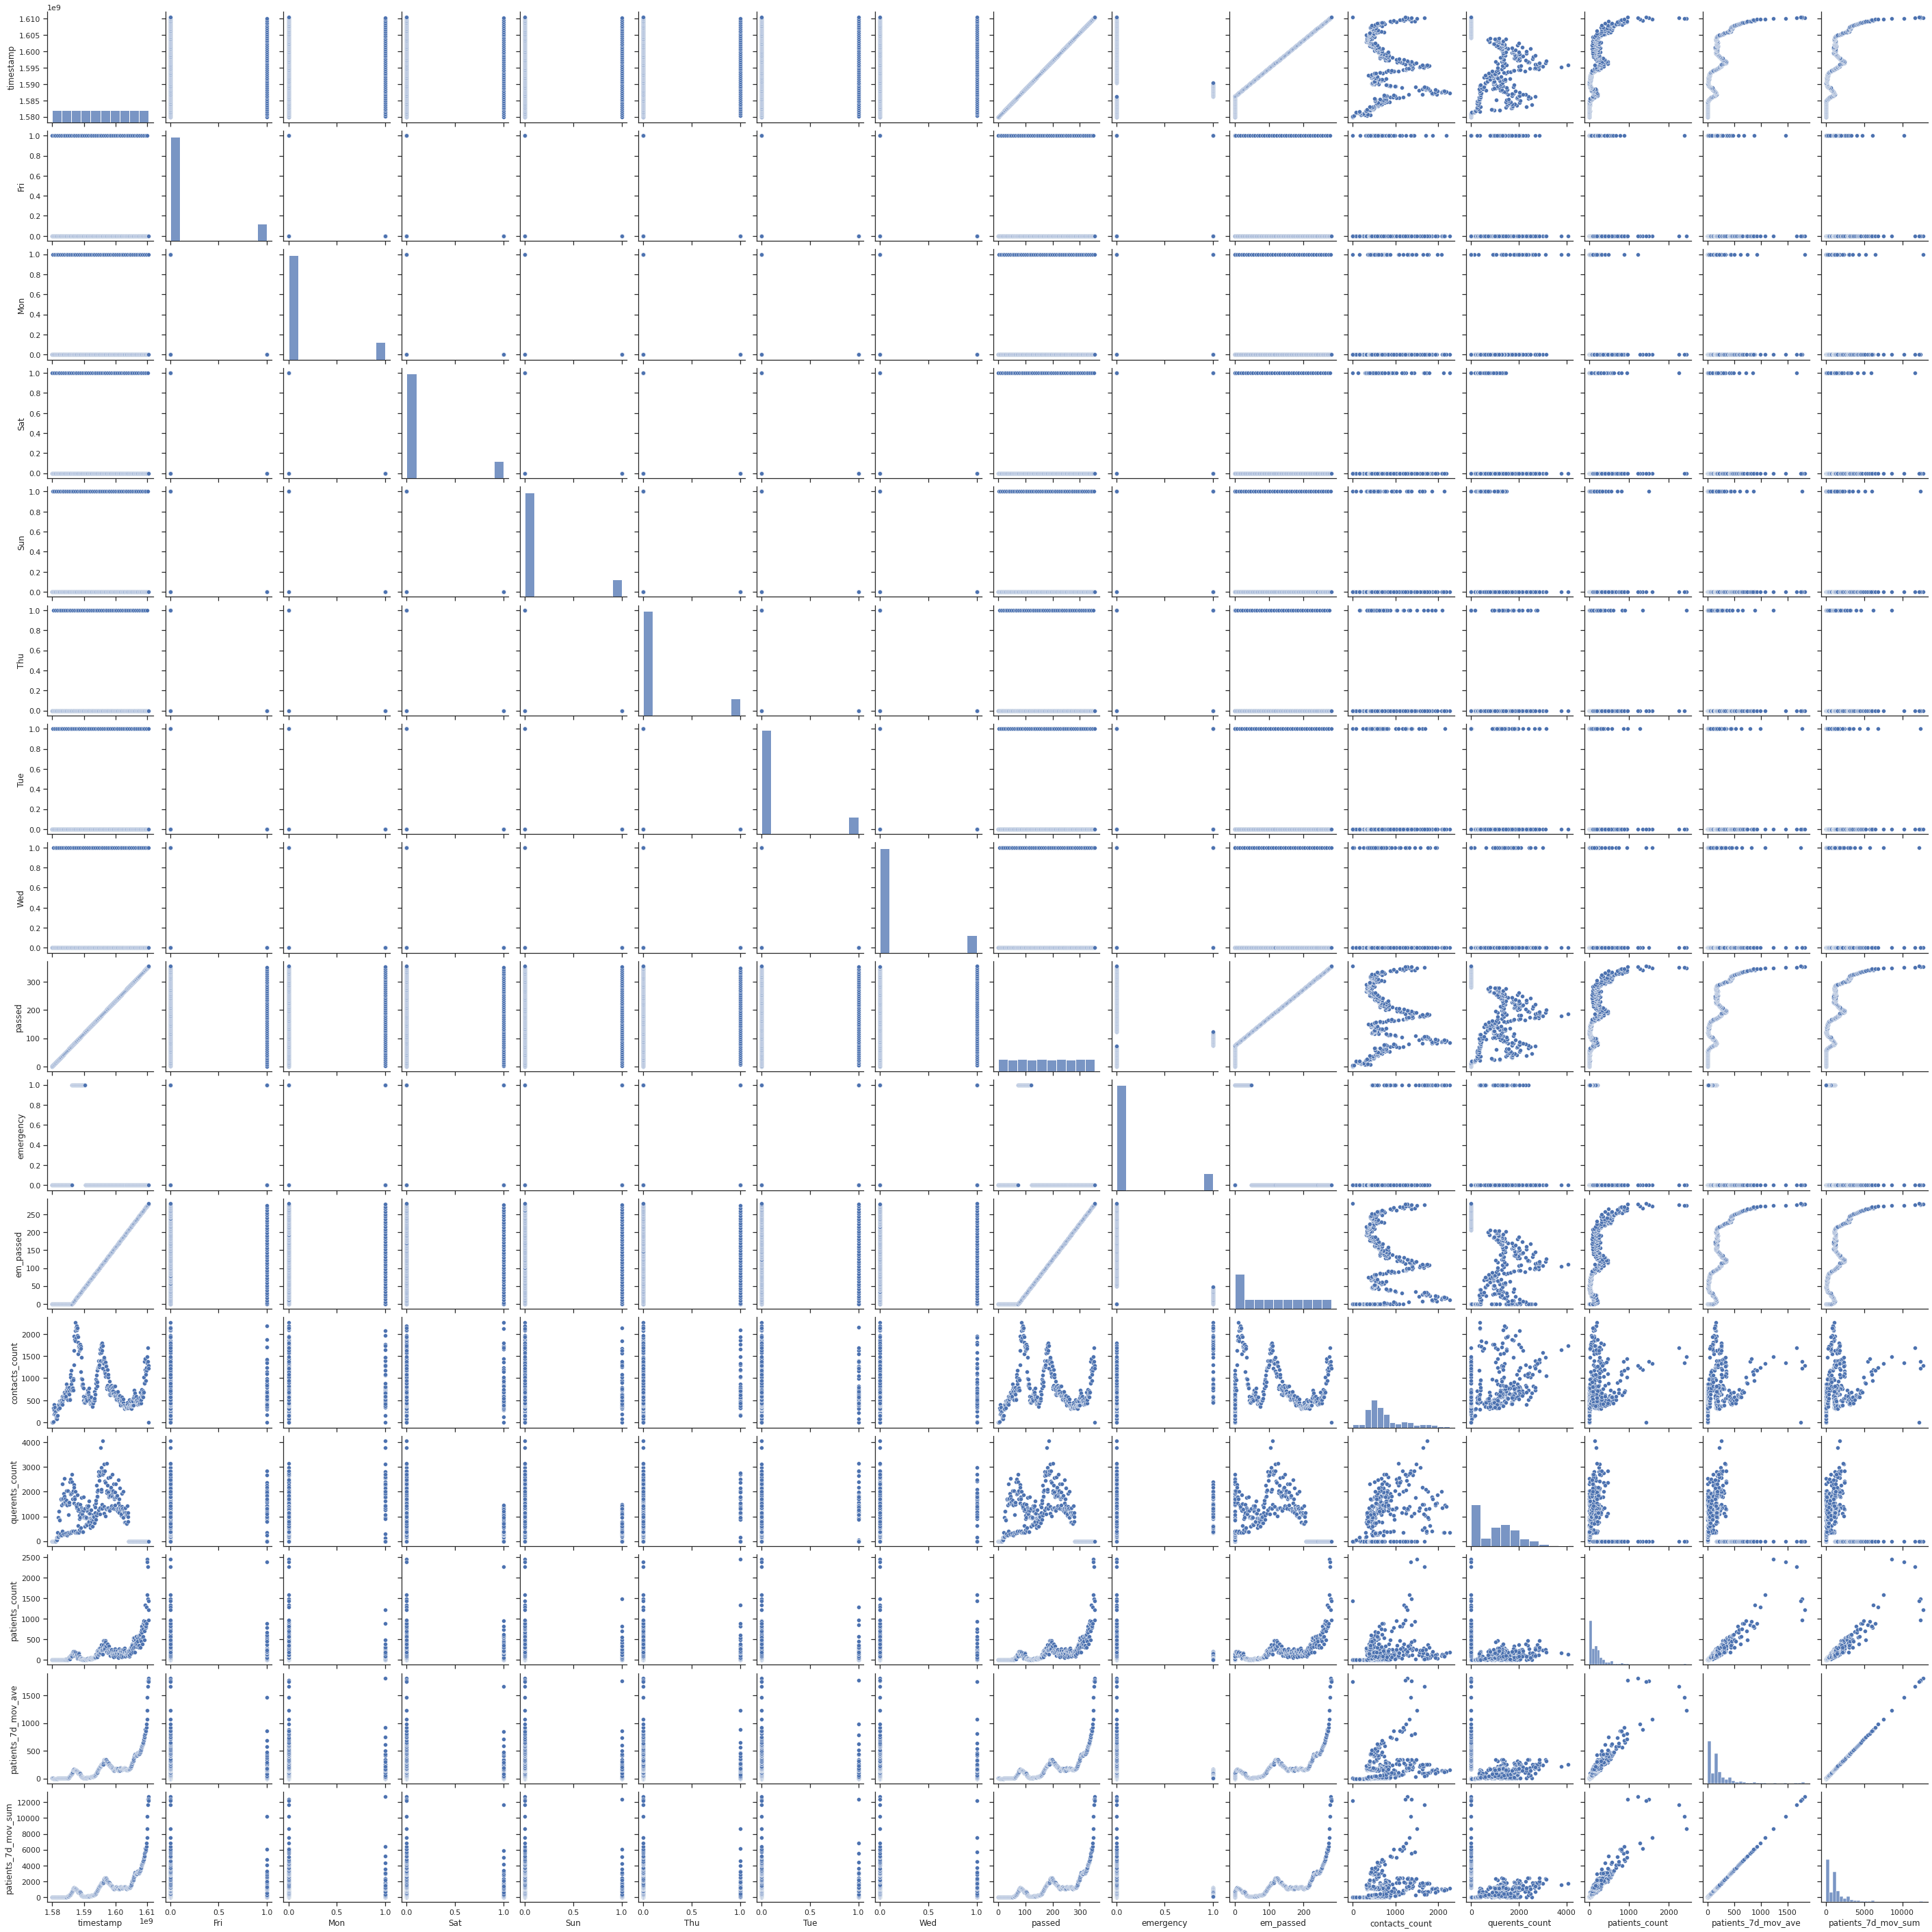

In [56]:
sns.set(style="ticks", color_codes=True)
sns.pairplot(data=_df)

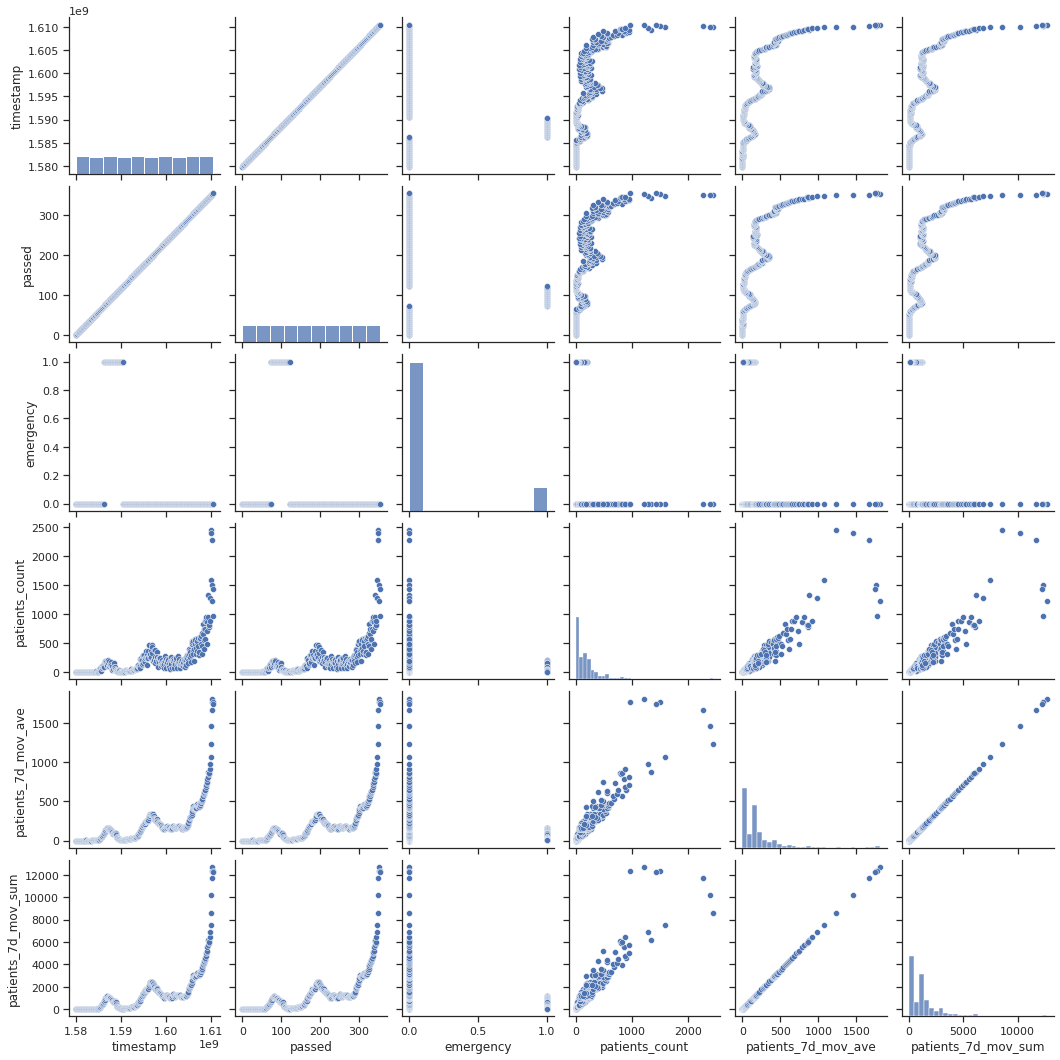

In [57]:
sns.pairplot(data=_df2)

In [58]:
!python -V

Python 3.6.9
